In [1]:
import math
import scipy
import statistics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import genpareto
from scipy.stats import t as studentt
from statistics import mean
from scipy.optimize import minimize
from scipy import signal

import paramonte as pm
import seaborn as sns

In [2]:
# Tide gauge data (daily max data) - The Battery, NY, USA
b_tg = pd.read_excel("B_DailyMaxTG.xlsx", sheet_name = "BDailyMaxTG")

# Overwash data from Cheesequake, NJ, USA
cq_od = pd.read_excel("B_DailyMaxTG.xlsx", sheet_name = "CQ_OE")

b_tg_t = b_tg['Time'] # Battery TG time
b_tg_h = b_tg['Max_Tide'] # Battery TG water levels
print(mean(b_tg_h))
b_tg_h = signal.detrend(b_tg_h, type == 'constant')

od_t = cq_od['meanYCE'] # mean ages of CQ overwash deposits

num_od = 4 # number of overwash deposits that do no overlap with tide gauge record

2476.1567622281723


In [3]:
b_detrended = pd.DataFrame(list(zip(b_tg_t, b_tg_h)), columns = ['t', 'h'])
b_detrended.to_excel("BatteryDetrended.xlsx")

540.2127560026192


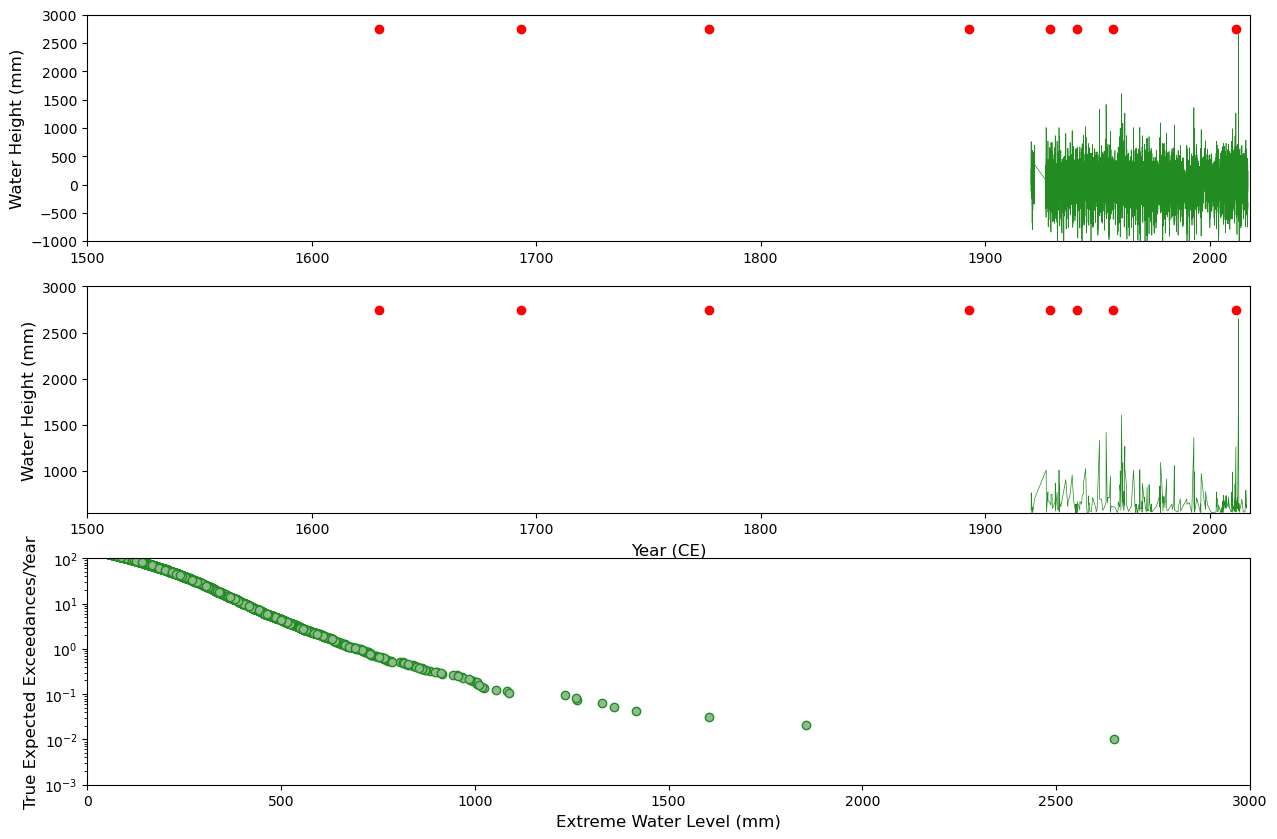

In [4]:
fig = plt.figure(figsize=(15,10))

# The Battery, NY tide gauge record (1920-2016 CE)
ax = fig.add_subplot(311)
plt.plot(b_tg_t, b_tg_h, linewidth = 0.5, color = 'forestgreen')
y = np.full((1,8), 2750)
plt.scatter(od_t, y, color = 'red')

ax.set_xlim(1500,2018)
ax.set_ylim(-1000,3000)
plt.ylabel('Water Height (mm)', fontsize = 12)

# 99th percentile of Woods Hole tide gauge record (1957-2016 CE)
q99 = np.quantile(b_tg_h, 0.99)
print(q99)
b_tg_h99 = b_tg_h[(b_tg_h >= q99)]
b_tg_t99 = b_tg_t[(b_tg_h >= q99)]

ax2 = fig.add_subplot(312)
plt.plot(b_tg_t99, b_tg_h99, linewidth = 0.5, color = 'forestgreen')
plt.scatter(od_t, y, color = 'red')

x1 = [-100, 2020]
y1 = [1448, 1448]

# plt.plot(x1,y1, color = 'orangered')

ax2.set_xlim(1500,2018)
ax2.set_ylim(540,3000)
plt.xlabel('Year (CE)', fontsize = 12)
plt.ylabel('Water Height (mm)', fontsize = 12)

# Empirical return curve & modeled return curve from Student's t distribution
#   based on Woods Hole tide gauge

ax3 = fig.add_subplot(313)

testexca = list(np.arange(-500.0, 3000.0, 10.0))
testexcb = b_tg_h
exceeded_tide = []

for i in range(0, len(testexcb)):
        exctg = sum(b_tg_h >= testexcb[i])/96.0
        exceeded_tide.append(exctg)
        
trueexc = (studentt.sf(testexca, 9.365, 0.8957, 199.2)*365)

plt.scatter(testexcb, exceeded_tide, facecolors = 'darkseagreen', edgecolors = 'forestgreen')
# plt.plot(testexca, trueexc, color = 'slategray')

ax3.set_yscale('log')
ax3.set_xlim([0, 3000])
ax3.set_ylim([1e-3, 1e2])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('True Expected Exceedances/Year', fontsize = 12)
# ax3.legend(["Modeled Curve from Student's t", "Woods Hole Tide Gauge Data"])

plt.savefig("CQandBData.pdf", bbox_inches = 'tight', dpi = 300)


In [5]:
b_detrended = pd.DataFrame(list(zip(testexcb, exceeded_tide)), columns = ['h', 'exceedances'])
b_detrended.to_excel("BatteryEmpiricalExceedances.xlsx")

In [6]:
# define functions to be optimized (log likelihoods)

def function_a(z, parameters): # just a funciton used in both likelihood functions
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    
    return (np.log(1 + (xi * ((z - mu)/phi))))

# negative log likelihood for tide data & proxy data    
def log_likelihood(parameters):
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    tau = parameters[3]
    tide_threshold = q99 # same as true location parameter
    
    tg_z = b_tg_h99 # tide gauge water levels from WH
    N = len(tg_z) # number of tide gauge water levels over tide_threshold
    M = num_od # number of overwash deposits in geologic record at MM

    t1 = 1600
    t2 = 2018
    t_tide = 1920
    
    ll_geo_tide = ((-1 * N * np.log(phi)) + ((-1 - (1/xi)) * np.sum(function_a(tg_z, parameters))) -
        ((M/xi) * np.log(1 + (xi * ((tau - mu)/phi)))) -
        ((t2 - t_tide) * (1 + ((xi * (q99 - mu))/phi))**(-1/xi)) -
        ((t_tide - t1) * (1 + ((xi * (tau - mu))/phi))**(-1/xi)))
    
    return(ll_geo_tide) 

# negative log likelihood for tide data only
def log_likelihood_tide(parameters):
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    tide_threshold = q99 # same as true location parameter
    
    tg_z = b_tg_h99
    N = len(tg_z)
    
    t2 = 2018
    t_tide = 1920 # start of tide gauge record
    
    ll_tide = ((-1 * N * np.log(phi)) +
        ((-1 - (1/xi)) * np.sum(function_a(tg_z, parameters))) -
        ((t2 - t_tide) * (1 + ((xi * (q99 - mu))/phi))**(-1/xi)))
    
    return(ll_tide)


In [7]:
# test negative log likelihood function - testing with true parameter values
parameters_0 = [600, 128.5, 0.188, 1200] # true parameter values
parameters_0tide = [600, 128.5, 0.188]

ans = log_likelihood(parameters_0)
print(ans)

ans1 = log_likelihood_tide(parameters_0tide)
print(ans1)

-1870.4157112243074
-1845.8006988121692


In [8]:
pmpd_tide = pm.ParaDRAM()

In [9]:
pmpd_tide.spec.overwriteRequested = True # overwrite the existing output files just in case they already exist.
pmpd_tide.spec.outputFileName = "./out/ESL&GS_S_CQ" # specify the output file prefixes.
pmpd_tide.spec.randomSeed = 12345 # set the random seed for the sake of reproducibity.
pmpd_tide.spec.variableNameList = ["mu", "phi", "xi"] # set the output names of the parameters.
pmpd_tide.spec.chainSize = 20000 # set the number of uniquely sampled points from the likelihood function.
pmpd_tide.spec.domainLowerLimitVec = [400, 100, 1e-10]
pmpd_tide.spec.domainUpperLimitVec = [1000, 500, 1]

In [10]:
pmpd_tide.runSampler( ndim = 3, # the number of parameters
               getLogFunc = log_likelihood_tide # the objective function to sample points from
               )


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                    

                                     20000 / 74281             0.3372 / 0.2690             1.0707 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_CQ_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readReport(

In [11]:
chain_tide = pmpd_tide.readChain(renabled = True)[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readChain()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the chain file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/ESL&GS_S_CQ*_chain.txt"


ParaDRAM - NOTE: processing chain file: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms/out/ESL&GS_S_CQ_process_1_chain.txt
ParaDRAM - NOTE: reading the file contents... done in 0.015809 seconds.
ParaDRAM - NOTE: ndim = 3, count = 20000
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: creating a heatm

In [15]:
chain_tide.plot.scatter.scatter.kws.cmap = "winter" # change the color-mapping from the default "autumn"
chain_tide.plot.scatter( ycolumns = "AdaptationMeasure" # choose the AdaptationMeasure column of the output chain file to plot
                  , ccolumns = [] # set the color of the points to empty from the default logLikelihood value.
                  )
chain_tide.plot.scatter.currentFig.axes.set_ylim([1.e-5,1])
chain_tide.plot.scatter.currentFig.axes.set_yscale("log")

ParaDRAM - NOTE: making the scatter plot... 

TypeError: FigureBase.gca() got an unexpected keyword argument 'alpha'

<Figure size 960x720 with 0 Axes>

In [12]:
sample_tide = pmpd_tide.readSample(renabled = True)[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readSample()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the sample file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/ESL&GS_S_CQ*_sample.txt"


ParaDRAM - NOTE: processing sample file: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms/out/ESL&GS_S_CQ_process_1_sample.txt
ParaDRAM - NOTE: reading the file contents... done in 0.002606 seconds.
ParaDRAM - NOTE: ndim = 3, count = 6415
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: creating a h

In [17]:
# plot the sampled variables

for colname in sample_tide.df.columns:
    sample_tide.plot.line.ycolumns = colname
    sample_tide.plot.line()
    sample_tide.plot.line.currentFig.axes.set_xlabel("MCMC Count")
    sample_tide.plot.line.currentFig.axes.set_ylabel(colname)
    sample_tide.plot.line.savefig( fname = "./out/traceplot_" + colname )

# plot the histograms of the sampled parameters

for colname in sample_tide.df.columns:
    sample_tide.plot.histplot(xcolumns = colname)
    sample_tide.plot.histplot.currentFig.axes.set_xlabel(colname)
    sample_tide.plot.histplot.currentFig.axes.set_ylabel("MCMC Count")
    sample_tide.plot.histplot.savefig( fname = "./out/histogram_" + colname )

ParaDRAM - NOTE: making the line plot... 

TypeError: FigureBase.gca() got an unexpected keyword argument 'alpha'

<Figure size 960x720 with 0 Axes>

In [13]:
sample_tide.df.mean()

SampleLogFunc   -1793.541315
mu                693.568407
phi               153.708711
xi                  0.241707
dtype: float64

In [14]:
sample_tide.df.std()

SampleLogFunc     1.212808
mu               14.105728
phi              11.655153
xi                0.069131
dtype: float64

In [15]:
sample_tide.df.quantile([0.05, 0.5, 0.95])

,SampleLogFunc,mu,phi,xi
0.05,-1796.01106,671.094101,136.034296,0.136243
0.50,-1793.23980,693.133700,152.942670,0.236085
0.95,-1792.20579,717.393451,174.154161,0.362912


ParaDRAM - NOTE: making the grid plot... 
generating subplot #1: (0,0) out of 9... done in 0.019035 seconds.
generating subplot #2: (0,1) out of 9... done in 0.101243 seconds.
generating subplot #3: (0,2) out of 9... done in 0.098147 seconds.
generating subplot #4: (1,0) out of 9... done in 0.232127 seconds.
generating subplot #5: (1,1) out of 9... done in 0.019035 seconds.
generating subplot #6: (1,2) out of 9... done in 0.101963 seconds.
generating subplot #7: (2,0) out of 9... done in 0.173361 seconds.
generating subplot #8: (2,1) out of 9... done in 0.167187 seconds.
generating subplot #9: (2,2) out of 9... done in 0.019035 seconds.
generating colorbar... done in 0.00937 seconds.


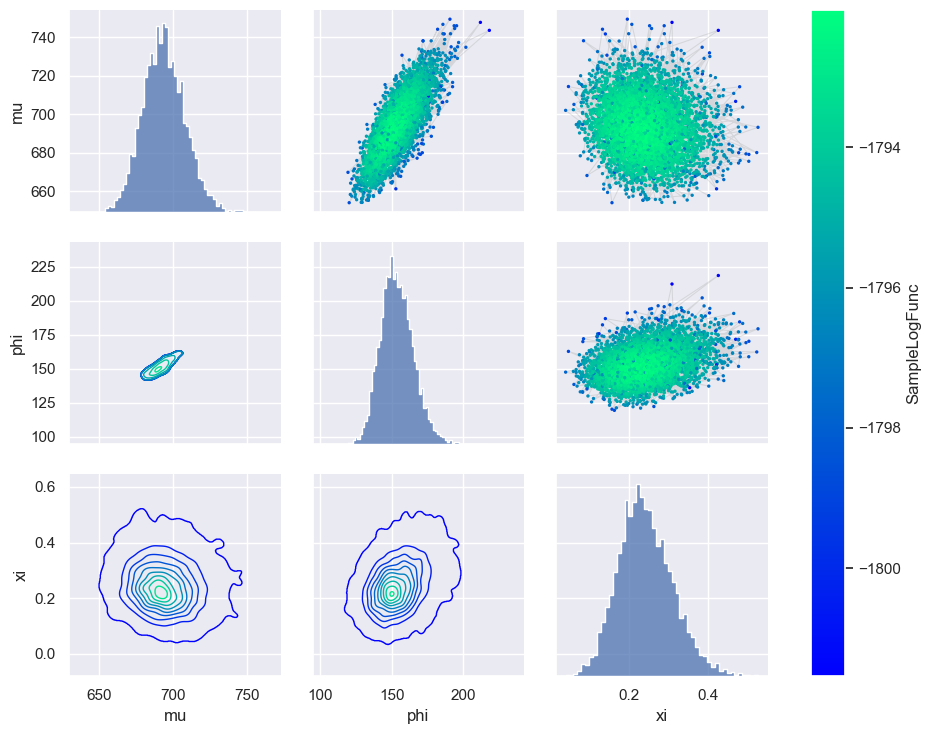

In [16]:
sample_tide.plot.grid.plotType.upper.enabled = True # disable upper triangle
sample_tide.plot.grid.plotType.lower.value = "contour" # let lower triangle be lineScatter plot
sample_tide.plot.grid(columns = [1,2,3]) # make grid plot of all parameters
# sample_tide.plot.grid.addTarget() # add the maximum-likelihood set of parameters as the target value to all plots

plt.savefig("CQ_MCMC_ParamValues", bbox_inches = 'tight', dpi = 300)


In [17]:
sample_tide.df

,SampleLogFunc,mu,phi,xi
0,-1796.9526,723.65382,181.82030,0.373409
1,-1793.2526,712.07563,159.45789,0.175815
2,-1792.5483,704.49352,155.69807,0.203303
3,-1794.4339,691.50858,141.34630,0.242932
4,-1793.0284,691.69484,146.89522,0.262894
...,...,...,...,...
6410,-1792.8283,679.25787,142.10148,0.275889
6411,-1792.7262,690.70048,156.94419,0.310453
6412,-1795.8681,690.21483,143.30105,0.075649
6413,-1795.0999,717.73681,172.48936,0.171219


In [18]:
z = []
for i in range(515, 5000):
    z.append(i) 
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append (x) # water heights to calculate return periods for

param_num = []
for x in range(0, len(sample_tide.df)):
    param_num.append(x)

def n_z_tide (z):
    
    mcmc_curves_tide = []
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    
    for i in range(0, 1000):
        
        expected_per_z = []
        
        for j in range(0, len(water_height_nums)):
            
            # optimized parameter values
            mu = sample_tide.df.loc[i, 'mu']
            phi = sample_tide.df.loc[i, 'phi']
            xi = sample_tide.df.loc[i, 'xi']
            
            c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
            expected_per_z.append(c)
            
        plt.plot(z, expected_per_z, color = 'lightgray')         
    
    plt.scatter(testexcb, exceeded_tide, facecolors = 'none', edgecolors = 'cyan', label = 'Empirical Exceedances', zorder = 10000)
    
    ax.set_yscale('log')
    ax.set_ylim([1e-3, 1e2])
    ax.set_xlim([0, 3000])
    plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
    plt.ylabel('True Expected Exceedances/Year', fontsize = 12)
    plt.legend(loc = "upper right")
    
    plt.savefig("CQ_MCMC_Curves", bbox_inches = 'tight', dpi = 300)

    
    return ()


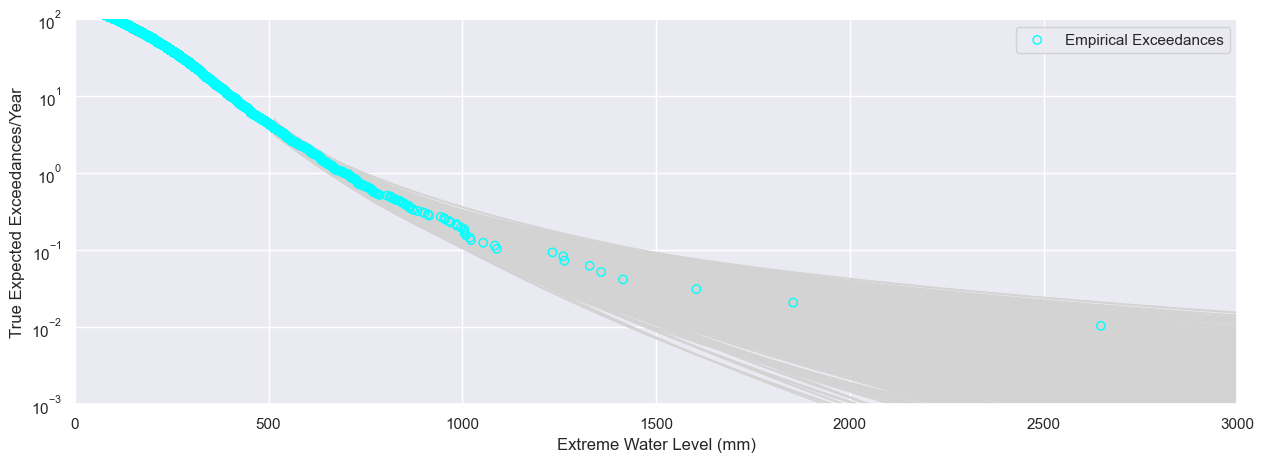

In [19]:
mcmc_curves_tide = n_z_tide(z)

In [20]:
pmpd_geo = pm.ParaDRAM()

In [21]:
pmpd_geo.spec.overwriteRequested = True # overwrite the existing output files just in case they already exist.
pmpd_geo.spec.outputFileName = "./out/ESL&GS_S_MCMC" # specify the output file prefixes.
pmpd_geo.spec.randomSeed = 12345 # set the random seed for the sake of reproducibity.
pmpd_geo.spec.variableNameList = ["mu", "phi", "xi", "tau"] # set the output names of the parameters.
pmpd_geo.spec.chainSize = 20000 # set the number of uniquely sampled points from the likelihood function.
pmpd_geo.spec.domainLowerLimitVec = [400, 100, 1e-10, 800]
pmpd_geo.spec.domainUpperLimitVec = [1000, 500, 1, 1600] 

In [22]:
pmpd_geo.runSampler( ndim = 4, # the number of parameters
               getLogFunc = log_likelihood # the objective function to sample points from
               )


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                    

                                     20000 / 85380             0.3011 / 0.2347             1.4343 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

In [23]:
chain_geo = pmpd_geo.readChain(renabled = True)[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readChain()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the chain file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/ESL&GS_S_MCMC*_chain.txt"


ParaDRAM - NOTE: processing chain file: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms/out/ESL&GS_S_MCMC_process_1_chain.txt
ParaDRAM - NOTE: reading the file contents... done in 0.02786 seconds.
ParaDRAM - NOTE: ndim = 4, count = 20000
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: creating a he

In [29]:
chain_geo.plot.scatter.scatter.kws.cmap = "winter" # change the color-mapping from the default "autumn"
chain_geo.plot.scatter( ycolumns = "AdaptationMeasure" # choose the AdaptationMeasure column of the output chain file to plot
                  , ccolumns = [] # set the color of the points to empty from the default logLikelihood value.
                  )
chain_geo.plot.scatter.currentFig.axes.set_ylim([1.e-5,1])
chain_geo.plot.scatter.currentFig.axes.set_yscale("log")

ParaDRAM - NOTE: making the scatter plot... 

TypeError: FigureBase.gca() got an unexpected keyword argument 'alpha'

<Figure size 960x720 with 0 Axes>

In [24]:
sample_geo = pmpd_geo.readSample(renabled = True)[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readSample()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the sample file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/ESL&GS_S_MCMC*_sample.txt"


ParaDRAM - NOTE: processing sample file: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms/out/ESL&GS_S_MCMC_process_1_sample.txt
ParaDRAM - NOTE: reading the file contents... done in 0.004977 seconds.
ParaDRAM - NOTE: ndim = 4, count = 2254
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: creating

In [31]:
for colname in sample_geo.df.columns:
    sample_geo.plot.line.ycolumns = colname
    sample_geo.plot.line()
    sample_geo.plot.line.currentFig.axes.set_xlabel("MCMC Count")
    sample_geo.plot.line.currentFig.axes.set_ylabel(colname)
    sample_geo.plot.line.savefig( fname = "./out/traceplot_" + colname )

# plot the histograms of the sampled parameters

for colname in sample_geo.df.columns:
    sample_geo.plot.histplot(xcolumns = colname)
    sample_geo.plot.histplot.currentFig.axes.set_xlabel(colname)
    sample_geo.plot.histplot.currentFig.axes.set_ylabel("MCMC Count")
    sample_geo.plot.histplot.savefig( fname = "./out/histogram_" + colname )

ParaDRAM - NOTE: making the line plot... 

TypeError: FigureBase.gca() got an unexpected keyword argument 'alpha'

<Figure size 960x720 with 0 Axes>

In [25]:
sample_geo.df.mean()

SampleLogFunc   -1816.059620
mu                688.321807
phi               144.308825
xi                  0.175939
tau              1499.132074
dtype: float64

In [26]:
sample_geo.df.std()

SampleLogFunc     1.367943
mu               12.818239
phi               8.745217
xi                0.047702
tau              68.932056
dtype: float64

In [27]:
sample_geo.df.quantile([0.05, 0.5, 0.95])

,SampleLogFunc,mu,phi,xi,tau
0.05,-1818.68361,667.764232,130.819007,0.101083,1366.016615
0.50,-1815.76160,687.988600,143.853450,0.174502,1511.184200
0.95,-1814.37977,709.970516,159.154176,0.255225,1590.438725


ParaDRAM - NOTE: making the grid plot... 
generating subplot #1: (0,0) out of 16... done in 0.018698 seconds.
generating subplot #2: (0,1) out of 16... done in 0.185187 seconds.
generating subplot #3: (0,2) out of 16... done in 0.18361 seconds.
generating subplot #4: (0,3) out of 16... done in 0.177541 seconds.
generating subplot #5: (1,0) out of 16... done in 0.254208 seconds.
generating subplot #6: (1,1) out of 16... done in 0.018698 seconds.
generating subplot #7: (1,2) out of 16... done in 0.175513 seconds.
generating subplot #8: (1,3) out of 16... done in 0.179155 seconds.
generating subplot #9: (2,0) out of 16... done in 0.249683 seconds.
generating subplot #10: (2,1) out of 16... done in 0.248848 seconds.
generating subplot #11: (2,2) out of 16... done in 0.018698 seconds.
generating subplot #12: (2,3) out of 16... done in 0.18244 seconds.
generating subplot #13: (3,0) out of 16... done in 0.235259 seconds.
generating subplot #14: (3,1) out of 16... done in 0.231409 seconds.
gen

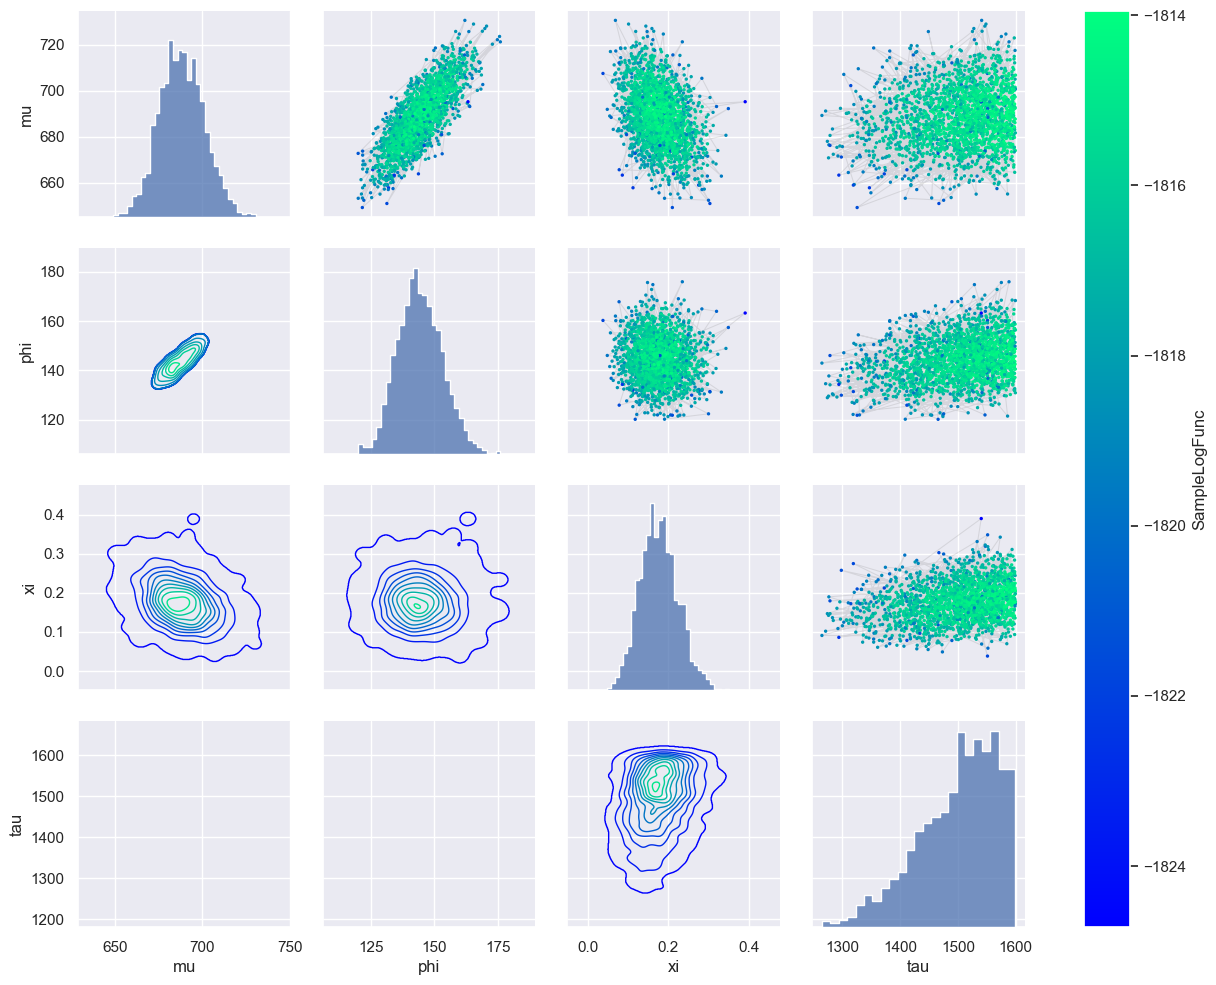

In [28]:
sample_geo.plot.grid.plotType.upper.enabled = True # disable upper triangle
sample_geo.plot.grid.plotType.lower.value = "contour" # let lower triangle be lineScatter plot
sample_geo.plot.grid(columns = [1,2,3,4]) # make grid plot of all parameters
# sample_geo.plot.grid.addTarget() # add the maximum-likelihood set of parameters as the target value to all plots

plt.savefig("CQ_MCMC_ParamsGeo", bbox_inches = 'tight', dpi = 300)


In [29]:
sample_geo.df

,SampleLogFunc,mu,phi,xi,tau
0,-1818.2542,699.72994,150.36181,0.138311,1323.5140
1,-1819.1762,666.01505,138.01794,0.228177,1358.7413
2,-1818.7601,662.68689,131.88736,0.244514,1368.3591
3,-1816.7562,685.47690,140.49733,0.113552,1339.3654
4,-1817.1042,687.80194,140.97210,0.172367,1334.1339
...,...,...,...,...,...
2249,-1815.0037,695.05325,151.89796,0.175352,1501.8294
2250,-1818.8548,691.17157,134.54044,0.101611,1271.1745
2251,-1818.4661,668.05628,122.73687,0.148868,1517.8776
2252,-1815.6612,687.67068,137.56917,0.123844,1418.0697


In [30]:
z = []
for i in range(515, 5000):
    z.append(i) 
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append (x) # water heights to calculate return periods for

param_num = []
for x in range(0, len(sample_geo.df)):
    param_num.append(x)

def n_z_geo (z):
    
    mcmc_curves_tide = []
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    
    for i in range(0, 1000):
        
        expected_per_z = []
        
        for j in range(0, len(water_height_nums)):
            
            # optimized parameter values
            mu = sample_geo.df.loc[i, 'mu']
            phi = sample_geo.df.loc[i, 'phi']
            xi = sample_geo.df.loc[i, 'xi']
            
            c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
            expected_per_z.append(c)
            
        plt.plot(z, expected_per_z, color = 'lightgray')         
    
    plt.scatter(testexcb, exceeded_tide, facecolors = 'none', edgecolors = 'cyan', label = 'Empirical Exceedances', zorder = 10000)

    ax.set_yscale('log')
    ax.set_ylim([1e-3, 1e2])
    ax.set_xlim([0, 3000])
    plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
    plt.ylabel('True Expected Exceedances/Year', fontsize = 12)
    plt.legend(loc = "upper right")
    
    plt.savefig("CQ_MCMC_RunsGeo", bbox_inches = 'tight', dpi = 300)

    
    return ()


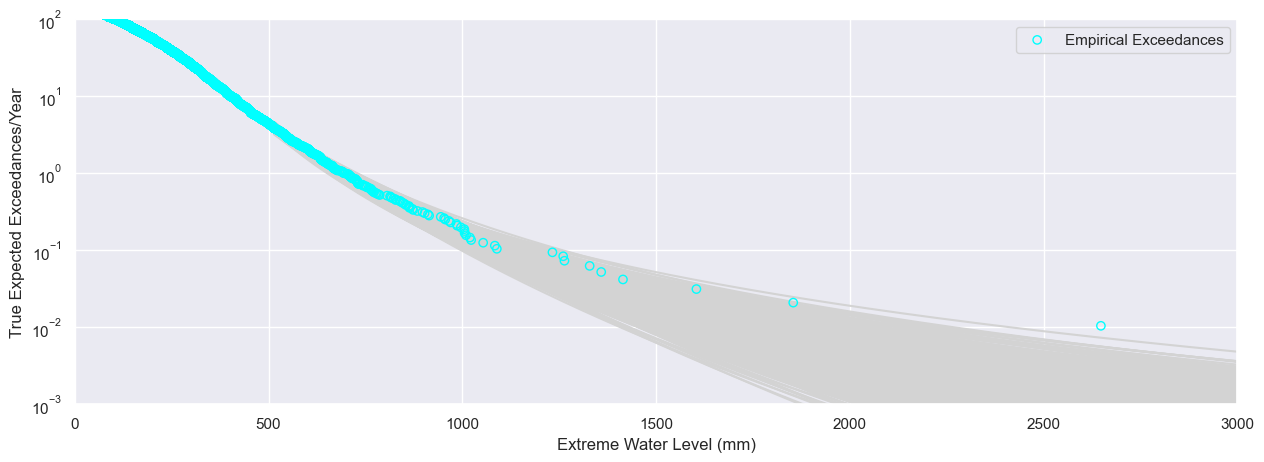

In [31]:
mcmc_curves_geo = n_z_geo(z)

In [32]:
params = pd.read_excel("syndataparams2.xlsx", sheet_name = 'CQ')
params.head()

,Unnamed: 0,mu5,mu50,mu95,phi5,phi50,phi95,xi5,xi50,xi95,color
0,tide,671.1,693.1,717.4,136.0,152.9,174.2,0.14,0.24,0.36,lightsteelblue
1,geo,667.8,688.0,710.0,130.8,143.9,159.2,0.10,0.17,0.26,slategray


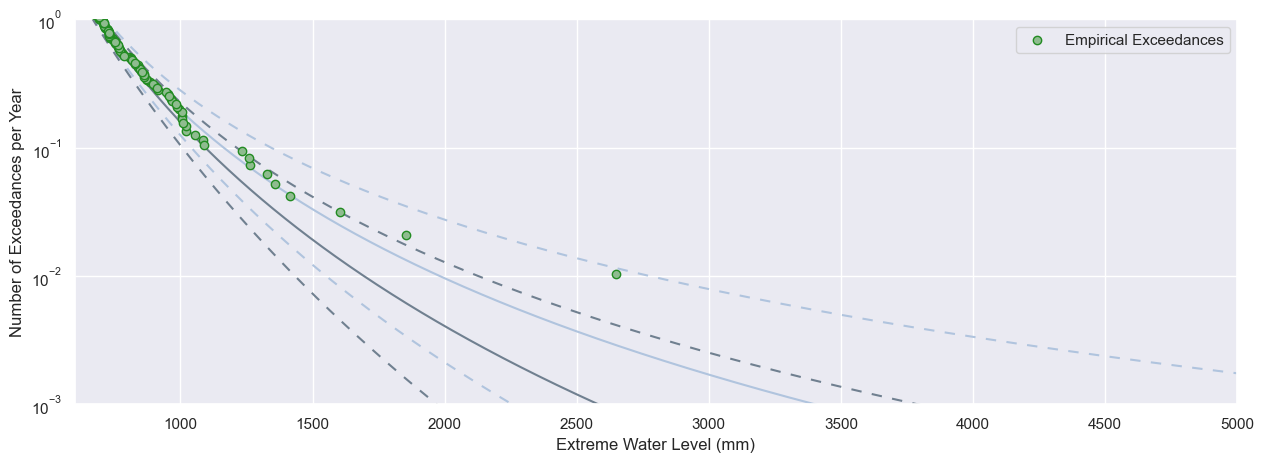

In [35]:
z = []
for i in range(515, 7000):
    z.append(i) 
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append (x) # water heights to calculate return periods for
    
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

for i in range(0, 2):
    
    expected_per_z = []

    for j in range(0, len(water_height_nums)):
            
        mu = params.loc[i, 'mu50']
        phi = params.loc[i, 'phi50']
        xi = params.loc[i, 'xi50']
            
        c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
        expected_per_z.append(c)
    
    color = params.loc[i, 'color']
    plt.plot(z, expected_per_z, color = color)
    expected_per_z = pd.DataFrame(list(zip(z, expected_per_z)), columns = ['z', '50'])
    expected_per_z.to_csv("B_MCMCexpectedperz50")
    
for i in range(0, 2):
    
    expected_per_z = []

    for j in range(0, len(water_height_nums)):
            
        mu = params.loc[i, 'mu5']
        phi = params.loc[i, 'phi5']
        xi = params.loc[i, 'xi5']
            
        c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
        expected_per_z.append(c)
    
    color = params.loc[i, 'color']
    plt.plot(z, expected_per_z, color = color, linestyle = (0, (5,5)))
    expected_per_z = pd.DataFrame(list(zip(z, expected_per_z)), columns = ['z', '5'])
    expected_per_z.to_csv("B_MCMCexpectedperz5")
    
for i in range(0, 2):
    
    expected_per_z = []

    for j in range(0, len(water_height_nums)):
            
        mu = params.loc[i, 'mu95']
        phi = params.loc[i, 'phi95']
        xi = params.loc[i, 'xi95']
            
        c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
        expected_per_z.append(c)
    
    color = params.loc[i, 'color']
    plt.plot(z, expected_per_z, color = color, linestyle = (0, (5,5))) 
    expected_per_z = pd.DataFrame(list(zip(z, expected_per_z)), columns = ['z', '95'])
    expected_per_z.to_csv("B_MCMCexpectedperz95")
    
# plt.plot(testz, testlogNexc, color = 'gray', label = 'True Return Curve')
plt.scatter(testexcb, exceeded_tide, facecolors = 'darkseagreen', edgecolors = 'forestgreen', label = 'Empirical Exceedances', zorder = 10000)

ax.set_yscale('log')
ax.set_ylim([1e-3, 1])
ax.set_xlim([600, 5000])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Number of Exceedances per Year', fontsize = 12)
plt.legend(loc = "upper right")
   
plt.savefig("CQ_MCMC_Compare.pdf", bbox_inches = 'tight', dpi = 300)    


In [ ]:
# CREATE MULTIPLE DATASETS VIA BOOTSTRAPPING

bs_q99 = []
bs_b_tg_h99 = []

for _ in range(1000):
    x = np.random.choice(b_tg_h, size = len(b_tg_h), replace = True)
    y = np.quantile(b_tg_h, 0.99)
    z = x[(x >= y)]
    bs_b_tg_h99.append(z)
    bs_q99.append(y)

In [ ]:
# MAXIMUM LIKELIHOOD ESTIMATION

def function_a(z, parameters): # just a funciton used in both likelihood functions
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    
    return (np.log(1 + (xi * ((z - mu)/phi))))

# negative log likelihood for tide data & proxy data    
def negative_log_likelihood(parameters, q99, num_od, b_tg_h99):
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    tau = parameters[3]
    tide_threshold = q99 
    
    tg_z = b_tg_h99 # tide gauge water levels from WH
    N = len(tg_z) # number of tide gauge water levels over tide_threshold
    M = num_od # number of overwash deposits in geologic record at MM

    t1 = 1600
    t2 = 2018
    t_tide = 1920
    
    nll_geo_tide = ((N * np.log(phi)) + ((1 + (1/xi)) * np.sum(function_a(tg_z, parameters))) +
        ((M/xi) * np.log(1 + (xi * ((tau - mu)/phi)))) +
        ((t2 - t_tide) * (1 + ((xi * (q99 - mu))/phi))**(-1/xi)) +
        ((t_tide - t1) * (1 + ((xi * (tau - mu))/phi))**(-1/xi)))
    
    return(nll_geo_tide) 

# negative log likelihood for tide data only
def negative_log_likelihood_tide(parameters, q99, b_tg_h99):
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    tide_threshold = q99
    
    tg_z = b_tg_h99
    N = len(tg_z)
    
    t2 = 2018
    t_tide = 1920 # start of tide gauge record
    
    nll_tide = ((N * np.log(phi)) +
        ((1 + (1/xi)) * np.sum(function_a(tg_z, parameters))) +
        ((t2 - t_tide) * (1 + ((xi * (q99 - mu))/phi))**(-1/xi)))
    
    return(nll_tide)



In [ ]:
parametersb = [600, 120.0, 0.1, 1500]
parametersa = [600, 120.0, 0.1]

# test negative log likelihood function - testing with true parameter values
ans = negative_log_likelihood(parametersb, q99, num_od, b_tg_h99)
print(ans)

ans1 = negative_log_likelihood_tide(parametersa, q99, b_tg_h99)
print(ans1)

In [ ]:
# MAXIMUM LIKELIHOOD ESTIMATES

# create single MLE
parametersa0 = [700, 200, 0.2] # starting values for optimization
parametersb0 = [700, 200, 0.2, 1400]

bndsa = ((0, 1000), (1, 800), (1e-3, 1))
bndsb = ((0, 1000), (1, 800), (1e-3, 1), (0,3000))

#result = scipy.optimize.minimize(negative_log_likelihood, parameters, method = 'Nelder-Mead')
result = scipy.optimize.minimize(negative_log_likelihood, parametersb0, args = (q99, num_od, b_tg_h99), method = 'Powell', bounds = bndsb)
print(result)
#result1 = scipy.optimize.minimize(negative_log_likelihood_tide, parameters, method = 'Nelder-Mead')
result1 = scipy.optimize.minimize(negative_log_likelihood_tide, parametersa0, args = (q99, b_tg_h99), method = 'Powell', bounds = bndsa)
print(result1)

In [ ]:
# CREATE MULTIPLE MLEs

def list_of_mles():
    
    mles = []            
    for i in range (0, num_its):
        bnds = ((0, 1000), (1, 500), (1e-3, 1), (0,3000))
        b = scipy.optimize.minimize(negative_log_likelihood, parametersb0, args = (bs_q99[i], num_od, bs_b_tg_h99[i]), method = 'Powell', bounds = bnds)
        mles.append(b)
            
    return(mles)
    
def list_of_mles_tide():
    
    mles_tide = []
    for i in range (0,num_its):
        bnds = ((0, 1000), (1, 800), (1e-3, 1))
        b = scipy.optimize.minimize(negative_log_likelihood_tide, parametersa0, args = (bs_q99[i], bs_b_tg_h99[i]), method = 'Powell', bounds = bnds)
        mles_tide.append(b)
        
    return(mles_tide)



In [ ]:
# LIST OF MLEs

num_its = 1000

mles = list_of_mles()
mles_tide = list_of_mles_tide()


In [ ]:
# PARAMETER ESTIMATES

mle_estimates = pd.DataFrame(mles)
parameter_estimates = mle_estimates['x']
parameter_estimates = parameter_estimates.tolist()
mus = [i[0] for i in parameter_estimates]
phis = [i[1] for i in parameter_estimates]
xis = [i[2] for i in parameter_estimates]
Ms = [i[3] for i in parameter_estimates]
parameter_estimates = pd.DataFrame(list(zip(mus, phis, xis, Ms)), columns = ['Mu', 'Phi', 'Xi', 'M'])

table_tide_parameters = parameter_estimates.describe(percentiles = [0.05, 0.50, 0.95])
table_tide_parameters.to_csv('TideParameterStats_BCQ_StationaryCase')

mle_estimates_tide = pd.DataFrame(mles_tide)
parameter_estimates_tide = mle_estimates_tide['x']
parameter_estimates_tide = parameter_estimates_tide.tolist()
mus_tide = [i[0] for i in parameter_estimates_tide]
phis_tide = [i[1] for i in parameter_estimates_tide]
xis_tide = [i[2] for i in parameter_estimates_tide]
parameter_estimates_tide = pd.DataFrame(list(zip(mus_tide, phis_tide, xis_tide)), columns = ['Mu', 'Phi', 'Xi'])

table_tide_parameters = parameter_estimates_tide.describe(percentiles = [0.05, 0.50, 0.95])
table_tide_parameters.to_csv('TideParameterStats_B_StationaryCase')


In [ ]:
# MODEL OUTPUTS FROM TG DATA ALONE 

testexca = list(np.arange(400, 5000, 1))

water_height_nums = []
for x in range(0, len(testexca)):
    water_height_nums.append (x)

param_num = []
for x in range(0, len(parameter_estimates_tide)):
    param_num.append(x)

# return values estimated by observable tide gauge data alone
def n_z_tide (z, parameter_estimates_tide):
    
    expected_annual_events_tide = []
    
    for i in range(0, len(water_height_nums)):
        expected_per_z = []
        for j in range(0, len(param_num)):
            
            # optimized parameter values
            mu = parameter_estimates_tide.loc[j, 'Mu']
            phi = parameter_estimates_tide.loc[j, 'Phi']
            xi = parameter_estimates_tide.loc[j, 'Xi']
            
            c = ((1 + (xi * (z[i] - mu)/phi))**(-1/xi))
            expected_per_z.append(c)
            
        expected_per_z = pd.DataFrame(expected_per_z)
        d = expected_per_z.quantile([0.05, 0.5, 0.95])
        d = d.values.tolist()
        expected_annual_events_tide.append(d)
            
    return (expected_annual_events_tide)
    

In [ ]:
expected_annual_events_tide = n_z_tide(testexca, parameter_estimates_tide)
expected_annual_events_tide = pd.DataFrame(expected_annual_events_tide)

In [ ]:
# MODEL OUTPUT FROM TIDE GAUGE AND GEOLOGIC DATA

water_height_nums = []
for x in range(0, len(testexca)):
    water_height_nums.append (x)

param_num = []
for x in range(0, len(parameter_estimates_tide)):
    param_num.append(x)

def n_z_geologic (z, parameter_estimates):
    
    expected_annual_events_geologic = []
    
    for i in range(0, len(water_height_nums)):
        expected_per_z = []
        for j in range(0, len(param_num)):
            
            # optimized parameters
            mu = parameter_estimates.loc[j, 'Mu']
            phi = parameter_estimates.loc[j, 'Phi']
            xi = parameter_estimates.loc[j, 'Xi']
            
            c = ((1 + (xi * (z[i]- mu)/phi))**(-1/xi))
            expected_per_z.append(c)
            
        expected_per_z = pd.DataFrame(expected_per_z)
        d = expected_per_z.quantile([0.05, 0.5, 0.95])
        d = d.values.tolist()
        expected_annual_events_geologic.append(d)
        
    return(expected_annual_events_geologic)

In [ ]:
expected_annual_events_geologic = n_z_geologic(testexca, parameter_estimates)
expected_annual_events_geologic = pd.DataFrame(expected_annual_events_geologic)

In [ ]:
# return curves from modeled parameter values
d_50_tide = expected_annual_events_tide.loc[:, 1]
d_50_tide = d_50_tide.tolist()
d_50_tidepd = pd.DataFrame(list(zip(testexca, d_50_tide)), columns = ['z', 'd_50'])
d_50_tidepd.to_csv('b_d_50')
d_5_tide = expected_annual_events_tide.loc[:, 0]
d_5_tide = d_5_tide.tolist()
d_5_tidepd = pd.DataFrame(list(zip(testexca, d_5_tide)), columns = ['z', 'd_5'])
d_5_tidepd.to_csv('b_d_5')
d_95_tide = expected_annual_events_tide.loc[:, 2]
d_95_tide = d_95_tide.tolist()
d_95_tidepd = pd.DataFrame(list(zip(testexca, d_95_tide)), columns = ['z', 'd_95'])
d_95_tidepd.to_csv('b_d_95')

d_50_geo = expected_annual_events_geologic.loc[:, 1]
d_50_geo = d_50_geo.tolist()
d_50_geopd = pd.DataFrame(list(zip(testexca, d_50_geo)), columns = ['z', 'd_50'])
d_50_geopd.to_csv('bcq_d_50')
d_5_geo = expected_annual_events_geologic.loc[:, 0]
d_5_geo = d_5_geo.tolist()
d_5_geopd = pd.DataFrame(list(zip(testexca, d_5_geo)), columns = ['z', 'd_5'])
d_5_geopd.to_csv('bcq_d_5')
d_95_geo = expected_annual_events_geologic.loc[:, 2]
d_95_geo = d_95_geo.tolist()
d_95_geopd = pd.DataFrame(list(zip(testexca, d_95_geo)), columns = ['z', 'd_95'])
d_95_geopd.to_csv('bcq_d_95')

In [ ]:
# plot true return curve against modeled curve using tide gauge data only
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(211)
# plt.plot(testexca, trueexc, color = 'slategray', label = 'Student t Distribution')
plt.scatter(testexcb, exceeded_tide, facecolors = 'yellow', edgecolors = 'gold', label = 'Empirical Tide Gauge Observations', zorder = 10)
plt.plot(testexca, d_50_tide, color = "lightcoral", label = 'Tide Gauge Data')
plt.plot(testexca, d_5_tide, linestyle = (0, (5,5)), color = "lightcoral")
plt.plot(testexca, d_95_tide, linestyle = (0, (5,5)), color = "lightcoral")
plt.plot(testexca, d_50_geo, color = "rosybrown", label = "Tide Gauge & Geologic Data with Modeled Geologic Threshold")
plt.plot(testexca, d_5_geo, linestyle = (0, (5,5)), color = "rosybrown")
plt.plot(testexca, d_95_geo, linestyle = (0, (5,5)), color = "rosybrown")
ax.set_yscale('log')
ax.set_ylim([1e-3, 1])
ax.set_xlim([600, 5000])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Expected Exceedances/Year', fontsize = 12)
plt.legend()

plt.savefig("CQ&BReturnCurves_Stationary_bootstrap", bbox_inches = 'tight', dpi = 300)



In [ ]:
# MCMC ESTIMATES

z = []
for i in range(515, 5000):
    z.append(i) 
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append (x) # water heights to calculate return periods for
    
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

for i in range(0, 2):
    
    expected_per_z = []

    for j in range(0, len(water_height_nums)):
            
        mu = params.loc[i, 'mu50']
        phi = params.loc[i, 'phi50']
        xi = params.loc[i, 'xi50']
            
        c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
        expected_per_z.append(c)
    
    color = params.loc[i, 'color']
    plt.plot(z, expected_per_z, color = color)
    
for i in range(0, 2):
    
    expected_per_z = []

    for j in range(0, len(water_height_nums)):
            
        mu = params.loc[i, 'mu5']
        phi = params.loc[i, 'phi5']
        xi = params.loc[i, 'xi5']
            
        c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
        expected_per_z.append(c)
    
    color = params.loc[i, 'color']
    plt.plot(z, expected_per_z, color = color, linestyle = (0, (5,5)))
    
for i in range(0, 2):
    
    expected_per_z = []

    for j in range(0, len(water_height_nums)):
            
        mu = params.loc[i, 'mu95']
        phi = params.loc[i, 'phi95']
        xi = params.loc[i, 'xi95']
            
        c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
        expected_per_z.append(c)
    
    color = params.loc[i, 'color']
    plt.plot(z, expected_per_z, color = color, linestyle = (0, (5,5))) 
    
# plt.plot(testz, testlogNexc, color = 'gray', label = 'True Return Curve')
plt.scatter(testexcb, exceeded_tide, facecolors = 'yellow', edgecolors = 'gold', label = 'Empirical Exceedances', zorder = 100)

#MLE ESTIMATES
plt.plot(testexca, d_50_tide, color = "lightcoral", label = 'Tide Gauge Data')
plt.plot(testexca, d_5_tide, linestyle = (0, (5,5)), color = "lightcoral")
plt.plot(testexca, d_95_tide, linestyle = (0, (5,5)), color = "lightcoral")
plt.plot(testexca, d_50_geo, color = "rosybrown", label = "Tide Gauge & Geologic Data with Modeled Geologic Threshold")
plt.plot(testexca, d_5_geo, linestyle = (0, (5,5)), color = "rosybrown")
plt.plot(testexca, d_95_geo, linestyle = (0, (5,5)), color = "rosybrown")

ax.set_yscale('log')
ax.set_ylim([1e-3, 10])
ax.set_xlim([435, 5000])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Number of Exceedances per Year', fontsize = 12)
plt.legend(loc = "upper right")

plt.savefig("CQ_MCMCMLE_Compare", bbox_inches = 'tight', dpi = 300)

    
